# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-random'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5827, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4929, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4691, Accuracy: 0.8166, F1 Micro: 0.2541, F1 Macro: 0.1855
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3982, Accuracy: 0.8419, F1 Micro: 0.4805, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3683, Accuracy: 0.8536, F1 Micro: 0.551, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2982, Accuracy: 0.8619, F1 Micro: 0.6173, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2597, Accuracy: 0.868, F1 Micro: 0.6793, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2216, Accuracy: 0.8684, F1 Micro: 0.6879, F1 Macro: 0.6795
Epoch 9/10, Train Loss: 0.1827, Accuracy: 0.873, F1 Micro: 0.6813, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5347, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4215, Accuracy: 0.8352, F1 Micro: 0.4063, F1 Macro: 0.3282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3473, Accuracy: 0.8703, F1 Micro: 0.6579, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2761, Accuracy: 0.8789, F1 Micro: 0.7057, F1 Macro: 0.6952
Epoch 5/10, Train Loss: 0.2095, Accuracy: 0.8822, F1 Micro: 0.7013, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.8823, F1 Micro: 0.7281, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8809, F1 Micro: 0.7288, F1 Macro: 0.7285
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.8791, F1 Micro: 0.7286, F1 Macro: 0.7257
Epoch 9/10, Train Loss: 0.0885, Accuracy: 0.8744, F1 Micro: 0.7282, F1 Macro: 0.7303
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.8227, F1 Micro: 0.2963, F1 Macro: 0.1947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.368, Accuracy: 0.8695, F1 Micro: 0.6883, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2878, Accuracy: 0.8872, F1 Micro: 0.7191, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2336, Accuracy: 0.89, F1 Micro: 0.7355, F1 Macro: 0.727
Epoch 5/10, Train Loss: 0.1779, Accuracy: 0.8934, F1 Micro: 0.7348, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.8875, F1 Micro: 0.7541, F1 Macro: 0.7548
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.8894, F1 Micro: 0.7528, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.8959, F1 Micro: 0.7546, F1 Macro: 0.7511
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.8914, F1 Micro: 0.7372, F1 Macro: 0.7325
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4817, Accuracy: 0.8302, F1 Micro: 0.3827, F1 Macro: 0.2743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3361, Accuracy: 0.8792, F1 Micro: 0.6831, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2675, Accuracy: 0.8916, F1 Micro: 0.7337, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2222, Accuracy: 0.8909, F1 Micro: 0.7578, F1 Macro: 0.7584
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.8967, F1 Micro: 0.7518, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.8959, F1 Micro: 0.7583, F1 Macro: 0.7543
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.8938, F1 Micro: 0.7338, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.8955, F1 Micro: 0.7363, F1 Macro: 0.7213
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.8942, F1 Micro: 0.7519, F1 Macro: 0.7424
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.8959, F1 Micro: 0.7398, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4763, Accuracy: 0.8486, F1 Micro: 0.5128, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3032, Accuracy: 0.8859, F1 Micro: 0.716, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2401, Accuracy: 0.8944, F1 Micro: 0.7432, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.897, F1 Micro: 0.7488, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9005, F1 Micro: 0.7673, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.8972, F1 Micro: 0.7733, F1 Macro: 0.7718
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.897, F1 Micro: 0.77, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.8967, F1 Micro: 0.7657, F1 Macro: 0.7612
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9011, F1 Micro: 0.7656, F1 Macro: 0.7557
Epoch 10/10, Train Loss: 0.0458, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.455, Accuracy: 0.8631, F1 Micro: 0.5926, F1 Macro: 0.555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.8848, F1 Micro: 0.7015, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2415, Accuracy: 0.8964, F1 Micro: 0.7655, F1 Macro: 0.76
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9006, F1 Micro: 0.7632, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.1475, Accuracy: 0.8991, F1 Micro: 0.7508, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9005, F1 Micro: 0.7679, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.8942, F1 Micro: 0.7323, F1 Macro: 0.7183
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.8988, F1 Micro: 0.7598, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9002, F1 Micro: 0.7681, F1 Macro: 0.7614
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9003, F1 Micro: 0.7658, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.445, Accuracy: 0.8606, F1 Micro: 0.5867, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.8925, F1 Micro: 0.7504, F1 Macro: 0.7451
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.8973, F1 Micro: 0.7458, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.8995, F1 Micro: 0.7762, F1 Macro: 0.7734
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9009, F1 Micro: 0.7657, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.902, F1 Micro: 0.7736, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9, F1 Micro: 0.7721, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.8991, F1 Micro: 0.7696, F1 Macro: 0.7616
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9013, F1 Micro: 0.7732, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0.8958, F1 Micro: 0.7685, F1 Macro: 0.7632
Iteration 3122: Accuracy: 0.8995, F1 Micro: 0.7762, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.428, Accuracy: 0.8753, F1 Micro: 0.6644, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8933, F1 Micro: 0.7558, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.8972, F1 Micro: 0.7652, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9041, F1 Micro: 0.7807, F1 Macro: 0.7761
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.8995, F1 Micro: 0.7782, F1 Macro: 0.7761
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.897, F1 Micro: 0.7514, F1 Macro: 0.7395
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9003, F1 Micro: 0.7665, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8978, F1 Micro: 0.7756, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.8995, F1 Micro: 0.7621, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.8975, F1 Micro: 0.773, F1 Macro: 0.771
Iteration 3432: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.416, Accuracy: 0.8772, F1 Micro: 0.6722, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.8941, F1 Micro: 0.7566, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.8969, F1 Micro: 0.7602, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.8977, F1 Micro: 0.7765, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.8995, F1 Micro: 0.7714, F1 Macro: 0.7621
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.8963, F1 Micro: 0.7601, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.8975, F1 Micro: 0.7733, F1 Macro: 0.7694
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.8945, F1 Micro: 0.7624, F1 Macro: 0.7569
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.8963, F1 Micro: 0.7612, F1 Macro: 0.7528
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.8981, F1 Micro: 0.7681, F1 Macro: 0.7637
Iteration 3711: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.8753, F1 Micro: 0.6826, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.8994, F1 Micro: 0.7638, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9025, F1 Micro: 0.7684, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9009, F1 Micro: 0.7777, F1 Macro: 0.7763
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9047, F1 Micro: 0.7769, F1 Macro: 0.772
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9022, F1 Micro: 0.7687, F1 Macro: 0.759
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.8997, F1 Micro: 0.7592, F1 Macro: 0.7527
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.902, F1 Micro: 0.7649, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9, F1 Micro: 0.7686, F1 Macro: 0.7651
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8977, F1 Micro: 0.766, F1 Macro: 0.7602
Iteration 3886: Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.878, F1 Micro: 0.6728, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8955, F1 Micro: 0.7499, F1 Macro: 0.745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9005, F1 Micro: 0.7584, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9031, F1 Micro: 0.771, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9039, F1 Micro: 0.772, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.8963, F1 Micro: 0.7458, F1 Macro: 0.7301
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9013, F1 Micro: 0.7819, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.8994, F1 Micro: 0.7702, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9017, F1 Micro: 0.7812, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0343, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4051, Accuracy: 0.8742, F1 Micro: 0.6489, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.8972, F1 Micro: 0.755, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9044, F1 Micro: 0.7722, F1 Macro: 0.763
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9013, F1 Micro: 0.7547, F1 Macro: 0.736
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.8995, F1 Micro: 0.7628, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.8972, F1 Micro: 0.7782, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.8988, F1 Micro: 0.7758, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.8994, F1 Micro: 0.7583, F1 Macro: 0.7481
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8964, F1 Micro: 0.7722, F1 Macro: 0.7698
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9009, F1 Micro: 0.7723, F1 Macro: 0.7696
Iteration 4330: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8773, F1 Micro: 0.6714, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.8963, F1 Micro: 0.7408, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9034, F1 Micro: 0.7799, F1 Macro: 0.7759
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9016, F1 Micro: 0.7663, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9005, F1 Micro: 0.7809, F1 Macro: 0.781
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9002, F1 Micro: 0.7728, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9042, F1 Micro: 0.7765, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9041, F1 Micro: 0.7849, F1 Macro: 0.7828
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9034, F1 Micro: 0.7648, F1 Macro: 0.76
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9042, F1 Micro: 0.7691, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8794, F1 Micro: 0.7203, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.8953, F1 Micro: 0.735, F1 Macro: 0.7073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.8973, F1 Micro: 0.7369, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.902, F1 Micro: 0.7696, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9009, F1 Micro: 0.7764, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9009, F1 Micro: 0.7737, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.8981, F1 Micro: 0.7646, F1 Macro: 0.7516
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9006, F1 Micro: 0.7701, F1 Macro: 0.7659
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.8995, F1 Micro: 0.768, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9002, F1 Micro: 0.7682, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8836, F1 Micro: 0.7188, F1 Macro: 0.7119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.8952, F1 Micro: 0.7366, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9036, F1 Micro: 0.7692, F1 Macro: 0.7599
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.8988, F1 Micro: 0.7374, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9016, F1 Micro: 0.7768, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8988, F1 Micro: 0.7733, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.903, F1 Micro: 0.7721, F1 Macro: 0.7703
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9017, F1 Micro: 0.7613, F1 Macro: 0.7572
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.8969, F1 Micro: 0.7712, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9019, F1 Micro: 0.7762, F1 Macro: 0.7742
Iteration 4863: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.882, F1 Micro: 0.7344, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.8938, F1 Micro: 0.7698, F1 Macro: 0.7693
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9031, F1 Micro: 0.7662, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8967, F1 Micro: 0.7745, F1 Macro: 0.7696
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.902, F1 Micro: 0.766, F1 Macro: 0.7523
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.8961, F1 Micro: 0.769, F1 Macro: 0.7665
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.8984, F1 Micro: 0.7635, F1 Macro: 0.7573
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.8967, F1 Micro: 0.7433, F1 Macro: 0.7319
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.8997, F1 Micro: 0.7717, F1 Macro: 0.7708
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9, F1 Micro: 0.7713, F1 Macro: 0.7649
Iteration 5063: Accuracy: 0.8967, F1 Micro: 0.7745, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8858, F1 Micro: 0.7418, F1 Macro: 0.7353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.8963, F1 Micro: 0.7601, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.8977, F1 Micro: 0.7804, F1 Macro: 0.7812
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9027, F1 Micro: 0.7737, F1 Macro: 0.7639
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.8997, F1 Micro: 0.7544, F1 Macro: 0.7416
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.8991, F1 Micro: 0.7748, F1 Macro: 0.773
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.8998, F1 Micro: 0.7598, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9005, F1 Micro: 0.7714, F1 Macro: 0.7678
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.897, F1 Micro: 0.7587, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.8975, F1 Micro: 0.7599, F1 Macro: 0.7556
Iteration 5263: Accuracy: 0.8977, F1 Micro: 0.7804, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8844, F1 Micro: 0.7407, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.8925, F1 Micro: 0.7684, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9033, F1 Micro: 0.7756, F1 Macro: 0.7664
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9009, F1 Micro: 0.7705, F1 Macro: 0.7651
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.903, F1 Micro: 0.7586, F1 Macro: 0.7412
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.8984, F1 Micro: 0.7684, F1 Macro: 0.763
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.8991, F1 Micro: 0.7618, F1 Macro: 0.7565
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9023, F1 Micro: 0.7726, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9006, F1 Micro: 0.772, F1 Macro: 0.7667
Iteration 5441: Accuracy: 0.9033, F1 Micro: 0.7756, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8845, F1 Micro: 0.7454, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.239, Accuracy: 0.8992, F1 Micro: 0.7633, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9095, F1 Micro: 0.7874, F1 Macro: 0.7821
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9027, F1 Micro: 0.7676, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9008, F1 Micro: 0.7759, F1 Macro: 0.7714
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9033, F1 Micro: 0.7766, F1 Macro: 0.7772
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9009, F1 Micro: 0.7535, F1 Macro: 0.7411
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9013, F1 Micro: 0.7787, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9016, F1 Micro: 0.7775, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9036, F1 Micro: 0.7797, F1 Macro: 0.7738
Iteration 5641: Accuracy: 0.9095, F1 Micro: 0.7874, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.887, F1 Micro: 0.7216, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.8994, F1 Micro: 0.7765, F1 Macro: 0.7741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2045, Accuracy: 0.9036, F1 Micro: 0.7772, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9048, F1 Micro: 0.7815, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9047, F1 Micro: 0.7846, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9044, F1 Micro: 0.7716, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9005, F1 Micro: 0.7714, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9034, F1 Micro: 0.7751, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9023, F1 Micro: 0.7791, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9016, F1 Micro: 0.7739, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3665, Accuracy: 0.8878, F1 Micro: 0.7516, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macro: 0.7753
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.8947, F1 Micro: 0.7765, F1 Macro: 0.7786
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.905, F1 Micro: 0.77, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.905, F1 Micro: 0.7853, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9028, F1 Micro: 0.7779, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9008, F1 Micro: 0.7799, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9027, F1 Micro: 0.7801, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.8997, F1 Micro: 0.7508, F1 Macro: 0.734
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9023, F1 Micro: 0.771, F1 Macro: 0.7656
Iteration 6041: Accuracy: 0.905, F1 Micro: 0.7853, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8875, F1 Micro: 0.7179, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9008, F1 Micro: 0.7585, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9027, F1 Micro: 0.7757, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9033, F1 Micro: 0.7796, F1 Macro: 0.7718
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9045, F1 Micro: 0.7706, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9016, F1 Micro: 0.7848, F1 Macro: 0.7843
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8994, F1 Micro: 0.7687, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.905, F1 Micro: 0.7889, F1 Macro: 0.7865
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8977, F1 Micro: 0.7707, F1 Macro: 0.77
Epoch 10/10, Train Loss: 0.0316, Accuracy: 

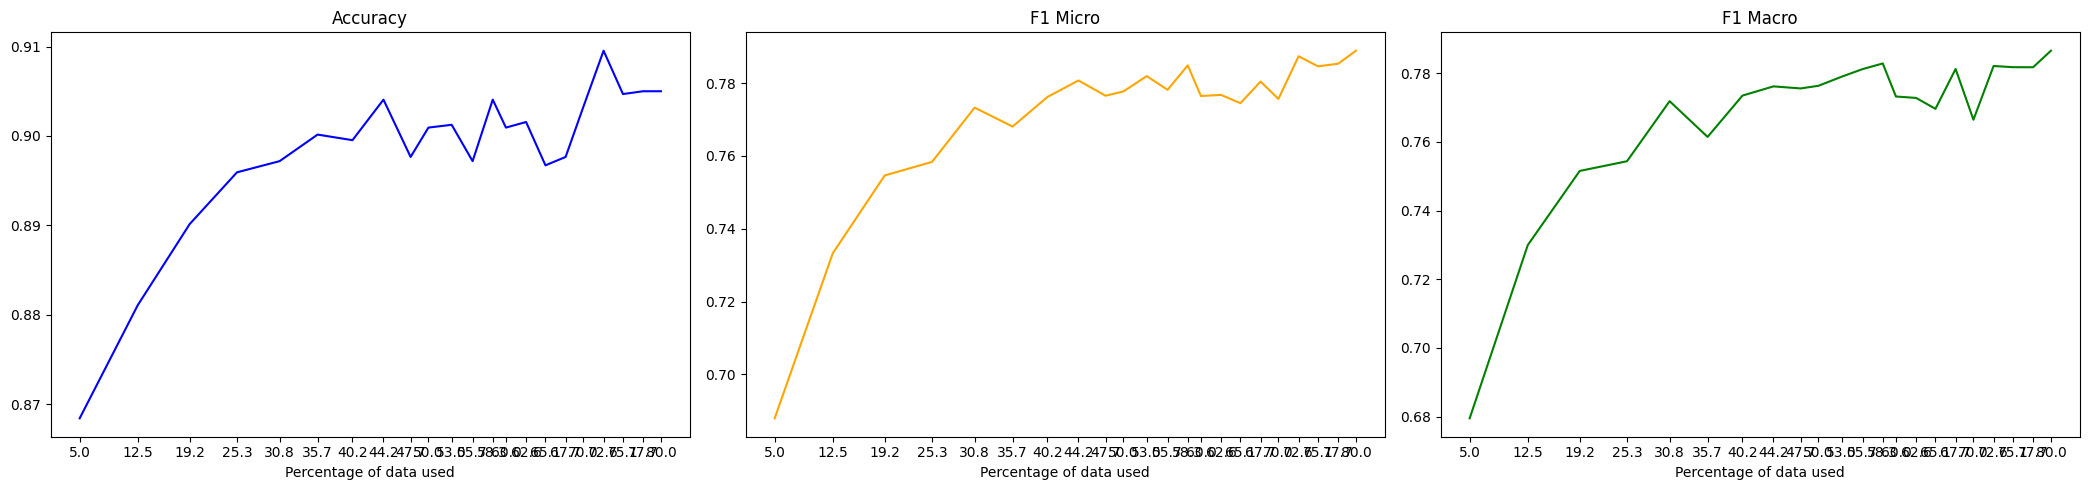

In [19]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5994, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4993, Accuracy: 0.7959, F1 Micro: 0.0829, F1 Macro: 0.0688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4403, Accuracy: 0.8245, F1 Micro: 0.3072, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4234, Accuracy: 0.8428, F1 Micro: 0.4672, F1 Macro: 0.3892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3468, Accuracy: 0.847, F1 Micro: 0.4972, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8569, F1 Micro: 0.5743, F1 Macro: 0.4944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2813, Accuracy: 0.8633, F1 Micro: 0.6167, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2386, Accuracy: 0.8723, F1 Micro: 0.6669, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1873,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5403, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4207, Accuracy: 0.8561, F1 Micro: 0.5842, F1 Macro: 0.5098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3458, Accuracy: 0.8737, F1 Micro: 0.6866, F1 Macro: 0.6828
Epoch 4/10, Train Loss: 0.2861, Accuracy: 0.8798, F1 Micro: 0.6852, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2338, Accuracy: 0.883, F1 Micro: 0.7024, F1 Macro: 0.6994
Epoch 6/10, Train Loss: 0.1894, Accuracy: 0.8831, F1 Micro: 0.6991, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1522, Accuracy: 0.8856, F1 Micro: 0.715, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.127, Accuracy: 0.8813, F1 Micro: 0.733, F1 Macro: 0.7312
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.8864, F1 Micro: 0.7203, F1 Macro: 0.7062
Epoch 10/10, Train Loss: 0.081, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5109, Accuracy: 0.83, F1 Micro: 0.3754, F1 Macro: 0.3249
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3669, Accuracy: 0.8706, F1 Micro: 0.6486, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.289, Accuracy: 0.8758, F1 Micro: 0.6554, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2228, Accuracy: 0.8858, F1 Micro: 0.6922, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.8825, F1 Micro: 0.7378, F1 Macro: 0.7377
Epoch 6/10, Train Loss: 0.1528, Accuracy: 0.8883, F1 Micro: 0.7076, F1 Macro: 0.6769
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.8908, F1 Micro: 0.7306, F1 Macro: 0.726
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.8922, F1 Micro: 0.7321, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.8917, F1 Micro: 0.7461, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4822, Accuracy: 0.853, F1 Micro: 0.6068, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.8739, F1 Micro: 0.6608, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2617, Accuracy: 0.8906, F1 Micro: 0.7514, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.8928, F1 Micro: 0.7591, F1 Macro: 0.7564
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.8955, F1 Micro: 0.7478, F1 Macro: 0.7435
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.8903, F1 Micro: 0.7544, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0957, Accuracy: 0.8964, F1 Micro: 0.7474, F1 Macro: 0.744
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.8927, F1 Micro: 0.7561, F1 Macro: 0.7508
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.8978, F1 Micro: 0.7534, F1 Macro: 0.7472
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.8984, F1 Micro: 0.7469, F1 Macro: 0.7365
Iteration 1969: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4567, Accuracy: 0.8494, F1 Micro: 0.5021, F1 Macro: 0.4141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2927, Accuracy: 0.8816, F1 Micro: 0.7383, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.8873, F1 Micro: 0.7543, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.8998, F1 Micro: 0.7551, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.893, F1 Micro: 0.7687, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.8955, F1 Micro: 0.7371, F1 Macro: 0.724
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9013, F1 Micro: 0.7636, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.8995, F1 Micro: 0.7654, F1 Macro: 0.7606
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.8995, F1 Micro: 0.7635, F1 Macro: 0.7547
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.8992, F1 Micro: 0.7666, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.445, Accuracy: 0.8727, F1 Micro: 0.689, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.8867, F1 Micro: 0.7066, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.8931, F1 Micro: 0.7641, F1 Macro: 0.7594
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9011, F1 Micro: 0.7509, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.8995, F1 Micro: 0.7691, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9003, F1 Micro: 0.7693, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.8992, F1 Micro: 0.7569, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.897, F1 Micro: 0.7679, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.8963, F1 Micro: 0.7667, F1 Macro: 0.7622
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9013, F1 Micro: 0.7611, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.8781, F1 Micro: 0.6777, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.8922, F1 Micro: 0.7244, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2199, Accuracy: 0.9014, F1 Micro: 0.7593, F1 Macro: 0.7462
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.8964, F1 Micro: 0.7439, F1 Macro: 0.7345
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9028, F1 Micro: 0.758, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9, F1 Micro: 0.7649, F1 Macro: 0.7565
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.8952, F1 Micro: 0.7633, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.8986, F1 Micro: 0.7685, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9011, F1 Micro: 0.7663, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.038, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8736, F1 Micro: 0.6619, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.8944, F1 Micro: 0.7422, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.223, Accuracy: 0.8961, F1 Micro: 0.7441, F1 Macro: 0.741
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.8964, F1 Micro: 0.7391, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9003, F1 Micro: 0.7542, F1 Macro: 0.7441
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.8989, F1 Micro: 0.7541, F1 Macro: 0.745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9003, F1 Micro: 0.7685, F1 Macro: 0.7584
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.895, F1 Micro: 0.7655, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8977, F1 Micro: 0.7673, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9, F1 Micro: 0.7596, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4166, Accuracy: 0.8755, F1 Micro: 0.6782, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.8944, F1 Micro: 0.7659, F1 Macro: 0.7619
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.8989, F1 Micro: 0.7612, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9019, F1 Micro: 0.7751, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.8998, F1 Micro: 0.7649, F1 Macro: 0.7548
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9, F1 Micro: 0.7589, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9005, F1 Micro: 0.7766, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9027, F1 Micro: 0.7732, F1 Macro: 0.7697
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9009, F1 Micro: 0.7629, F1 Macro: 0.759
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.8992, F1 Micro: 0.776, F1 Macro: 0.7756
Iteration 3711: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8788, F1 Micro: 0.7184, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.8969, F1 Micro: 0.7532, F1 Macro: 0.747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9, F1 Micro: 0.7617, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9019, F1 Micro: 0.7644, F1 Macro: 0.7541
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9034, F1 Micro: 0.7641, F1 Macro: 0.7555
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9022, F1 Micro: 0.7577, F1 Macro: 0.7453
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.8977, F1 Micro: 0.7584, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9002, F1 Micro: 0.7754, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.8778, F1 Micro: 0.6761, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.8992, F1 Micro: 0.7548, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9027, F1 Micro: 0.7722, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9041, F1 Micro: 0.7642, F1 Macro: 0.7529
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9011, F1 Micro: 0.7655, F1 Macro: 0.7558
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9017, F1 Micro: 0.7715, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.8994, F1 Micro: 0.7655, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.8992, F1 Micro: 0.7717, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.898, F1 Micro: 0.7741, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9, F1 Micro: 0.7663, F1 Macro: 0.7582
Iteration 4120: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4036, Accuracy: 0.8763, F1 Micro: 0.6627, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.8975, F1 Micro: 0.7539, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9047, F1 Micro: 0.7639, F1 Macro: 0.7601
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9014, F1 Micro: 0.754, F1 Macro: 0.7445
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.8942, F1 Micro: 0.7215, F1 Macro: 0.7047
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9, F1 Micro: 0.7615, F1 Macro: 0.7473
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.897, F1 Micro: 0.747, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9031, F1 Micro: 0.765, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9014, F1 Micro: 0.77, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.901

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3977, Accuracy: 0.8831, F1 Micro: 0.7103, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8972, F1 Micro: 0.7611, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9019, F1 Micro: 0.7669, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.8969, F1 Micro: 0.7689, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9039, F1 Micro: 0.7769, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9022, F1 Micro: 0.77, F1 Macro: 0.7596
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9003, F1 Micro: 0.7705, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9008, F1 Micro: 0.7637, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9009, F1 Micro: 0.7662, F1 Macro: 0.759
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9031, F1 Micro: 0.7724, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8841, F1 Micro: 0.6969, F1 Macro: 0.6856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8975, F1 Micro: 0.7599, F1 Macro: 0.7541
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.8938, F1 Micro: 0.7031, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9022, F1 Micro: 0.7688, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.8953, F1 Micro: 0.772, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9058, F1 Micro: 0.7729, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.9044, F1 Micro: 0.7723, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.8995, F1 Micro: 0.7704, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.0325, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8841, F1 Micro: 0.6947, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.8945, F1 Micro: 0.7686, F1 Macro: 0.763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9036, F1 Micro: 0.7756, F1 Macro: 0.7596
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.8988, F1 Micro: 0.7459, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9028, F1 Micro: 0.7782, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9009, F1 Micro: 0.7598, F1 Macro: 0.7539
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9036, F1 Micro: 0.7762, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9011, F1 Micro: 0.763, F1 Macro: 0.7547
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9003, F1 Micro: 0.7639, F1 Macro: 0.757
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8984, F1 Micro: 0.7769, F1 Macro: 0.7761
Iteration 4863: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8864, F1 Micro: 0.7141, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.902, F1 Micro: 0.7762, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.903, F1 Micro: 0.7806, F1 Macro: 0.7778
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9005, F1 Micro: 0.7792, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.0861, Accuracy: 0.9027, F1 Micro: 0.774, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9016, F1 Micro: 0.7825, F1 Macro: 0.7831
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9044, F1 Micro: 0.7765, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9053, F1 Micro: 0.7848, F1 Macro: 0.7847
Epoch 10/10, Train Loss: 0.0302, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8903, F1 Micro: 0.7367, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2377, Accuracy: 0.8992, F1 Micro: 0.761, F1 Macro: 0.754
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.8994, F1 Micro: 0.7568, F1 Macro: 0.7444
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9013, F1 Micro: 0.7474, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9025, F1 Micro: 0.7613, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.8983, F1 Micro: 0.7635, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.8984, F1 Micro: 0.7705, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9019, F1 Micro: 0.7728, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8902, F1 Micro: 0.7205, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2316, Accuracy: 0.8989, F1 Micro: 0.7697, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7711
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.8991, F1 Micro: 0.7666, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9045, F1 Micro: 0.7663, F1 Macro: 0.7563
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.903, F1 Micro: 0.7723, F1 Macro: 0.7664
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9022, F1 Micro: 0.7717, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7641
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9008, F1 Micro: 0.7777, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.8994, F1 Micro: 0.7615, F1 Macro: 0.7559
Iteration 5441: Accuracy: 0.9016, F1 Micro: 0.778, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8892, F1 Micro: 0.7566, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.902, F1 Micro: 0.7718, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.905, F1 Micro: 0.7818, F1 Macro: 0.7762
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9016, F1 Micro: 0.7782, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9003, F1 Micro: 0.7818, F1 Macro: 0.7799
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8975, F1 Micro: 0.7652, F1 Macro: 0.7581
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9023, F1 Micro: 0.7708, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9, F1 Micro: 0.7706, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9039, F1 Micro: 0.7818, F1 Macro: 0.7826
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9023, F1 Micro: 0.7711, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3654, Accuracy: 0.8888, F1 Micro: 0.7255, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9028, F1 Micro: 0.7708, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9092, F1 Micro: 0.782, F1 Macro: 0.7741
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9023, F1 Micro: 0.7791, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.8952, F1 Micro: 0.7545, F1 Macro: 0.747
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.8997, F1 Micro: 0.7694, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9019, F1 Micro: 0.7739, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.9027, F1 Micro: 0.7755, F1 Macro: 0.7732
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9014, F1 Micro: 0.7742, F1 Macro: 0.7746
Iteration 5841: Accuracy: 0.9092, F1 Micro: 0.782, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3614, Accuracy: 0.8895, F1 Micro: 0.72, F1 Macro: 0.712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2369, Accuracy: 0.9027, F1 Micro: 0.7763, F1 Macro: 0.772
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.8963, F1 Micro: 0.7148, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9047, F1 Micro: 0.7846, F1 Macro: 0.7827
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9044, F1 Micro: 0.7841, F1 Macro: 0.7803
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9002, F1 Micro: 0.7787, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.8998, F1 Micro: 0.7613, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.7774
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9053, F1 Micro: 0.7843, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9036, F1 Micro: 0.7821, F1 Macro: 0.7801
Iteration 6041: Accuracy: 0.9047, F1 Micro: 0.7846, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3623, Accuracy: 0.8883, F1 Micro: 0.6995, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.8994, F1 Micro: 0.7559, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9064, F1 Micro: 0.784, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.903, F1 Micro: 0.7858, F1 Macro: 0.7856
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9023, F1 Micro: 0.7823, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9028, F1 Micro: 0.7785, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0681, Accuracy: 0.9041, F1 Micro: 0.7721, F1 Macro: 0.7621
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.905, F1 Micro: 0.7784, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9034, F1 Micro: 0.7749, F1 Macro: 0.7675
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9009, F1 Micro: 0.7775, F1 Macro: 0.776
Iteration 6218: Accur

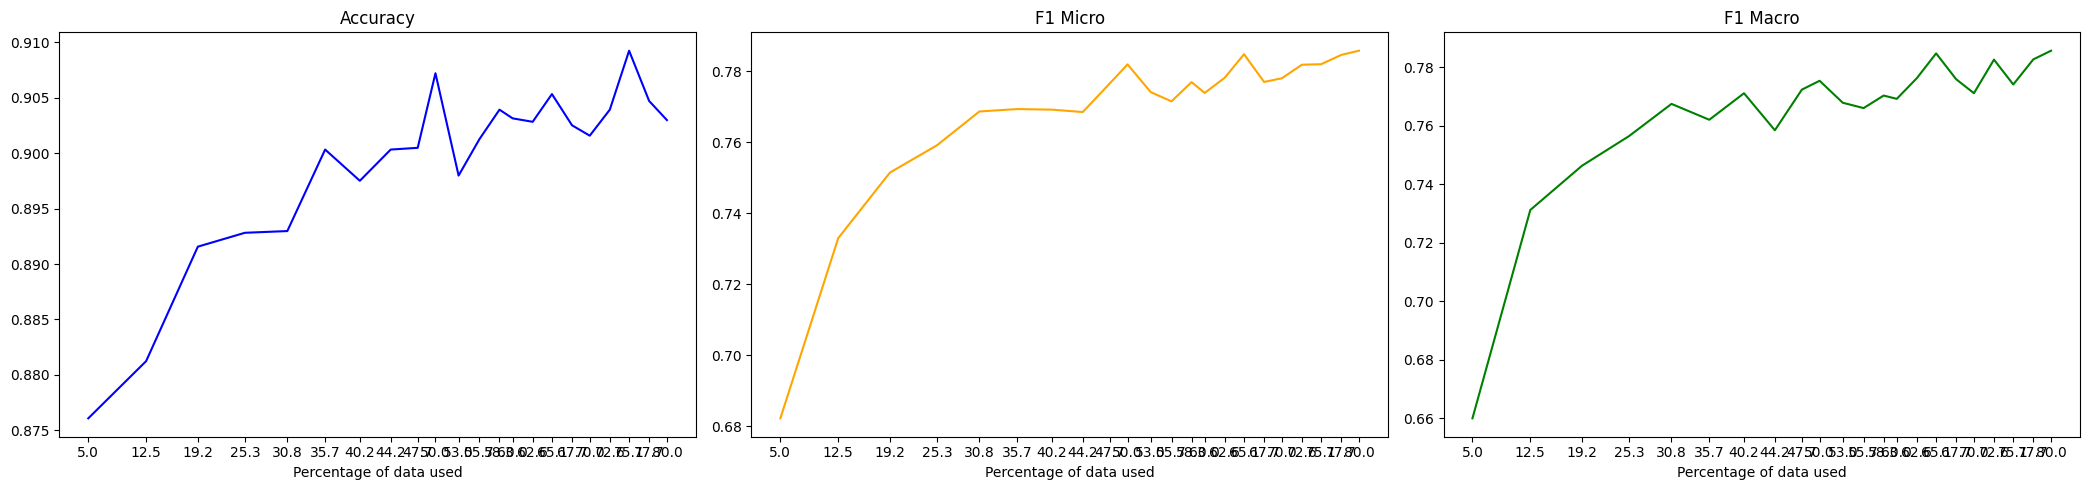

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5844, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4307, Accuracy: 0.7905, F1 Micro: 0.0346, F1 Macro: 0.0305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4004, Accuracy: 0.8223, F1 Micro: 0.2871, F1 Macro: 0.2055
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3618, Accuracy: 0.8373, F1 Micro: 0.4148, F1 Macro: 0.3304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.303, Accuracy: 0.8416, F1 Micro: 0.4416, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2804, Accuracy: 0.8517, F1 Micro: 0.5286, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2304, Accuracy: 0.8625, F1 Micro: 0.6068, F1 Macro: 0.5746
Epoch 8/10, Train Loss: 0.199, Accuracy: 0.8653, F1 Micro: 0.6009, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1798, Accuracy: 0.8691, F1 Micro: 0.64

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5315, Accuracy: 0.805, F1 Micro: 0.1579, F1 Macro: 0.1201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8345, F1 Micro: 0.4, F1 Macro: 0.3229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3337, Accuracy: 0.8661, F1 Micro: 0.6141, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.256, Accuracy: 0.8772, F1 Micro: 0.6836, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2052, Accuracy: 0.8816, F1 Micro: 0.6916, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1698, Accuracy: 0.8842, F1 Micro: 0.7269, F1 Macro: 0.7242
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.8838, F1 Micro: 0.7228, F1 Macro: 0.7178
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.8875, F1 Micro: 0.7211, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.8844, F1 Micro: 0.7305, F1 Macro: 0.7235
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4953, Accuracy: 0.8164, F1 Micro: 0.2482, F1 Macro: 0.1768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3571, Accuracy: 0.8695, F1 Micro: 0.6421, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.279, Accuracy: 0.8856, F1 Micro: 0.721, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.8923, F1 Micro: 0.7284, F1 Macro: 0.714
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.8861, F1 Micro: 0.6902, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.8913, F1 Micro: 0.7432, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.8923, F1 Micro: 0.7355, F1 Macro: 0.7235
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.8909, F1 Micro: 0.7382, F1 Macro: 0.727
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.8911, F1 Micro: 0.7204, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0477, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8339, F1 Micro: 0.3887, F1 Macro: 0.318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.8789, F1 Micro: 0.7249, F1 Macro: 0.723
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.8859, F1 Micro: 0.7082, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.8934, F1 Micro: 0.7385, F1 Macro: 0.7304
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.8922, F1 Micro: 0.7151, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.8953, F1 Micro: 0.7493, F1 Macro: 0.7467
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.8922, F1 Micro: 0.7334, F1 Macro: 0.7263
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8945, F1 Micro: 0.7417, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8964, F1 Micro: 0.7544, F1 Macro: 0.7507
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.8922, F1 Micro: 0.7513, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8572, F1 Micro: 0.5956, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.8864, F1 Micro: 0.7188, F1 Macro: 0.7195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.8933, F1 Micro: 0.7473, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.8941, F1 Micro: 0.7608, F1 Macro: 0.7599
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.8944, F1 Micro: 0.7596, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.8955, F1 Micro: 0.7471, F1 Macro: 0.7404
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.8952, F1 Micro: 0.7486, F1 Macro: 0.7434
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.8927, F1 Micro: 0.7515, F1 Macro: 0.7476
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8947, F1 Micro: 0.7479, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8945, F1 Micro: 0.7423, F1 Macro: 0.7359
Iteration 2394: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8652, F1 Micro: 0.6058, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.8858, F1 Micro: 0.7163, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8911, F1 Micro: 0.7182, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.8939, F1 Micro: 0.7687, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.898, F1 Micro: 0.757, F1 Macro: 0.7509
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.8995, F1 Micro: 0.755, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.8869, F1 Micro: 0.7544, F1 Macro: 0.7513
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.8984, F1 Micro: 0.7575, F1 Macro: 0.7511
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8959, F1 Micro: 0.7637, F1 Macro: 0.7617
Iteration 2777: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8597, F1 Micro: 0.572, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.893, F1 Micro: 0.7503, F1 Macro: 0.7394
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.8927, F1 Micro: 0.7231, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.8939, F1 Micro: 0.7579, F1 Macro: 0.7523
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.8978, F1 Micro: 0.7439, F1 Macro: 0.7303
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9006, F1 Micro: 0.7556, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8955, F1 Micro: 0.7615, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.8906, F1 Micro: 0.7598, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.8975, F1 Micro: 0.762, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0361, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8769, F1 Micro: 0.6934, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.8911, F1 Micro: 0.7229, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.8994, F1 Micro: 0.7568, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.8978, F1 Micro: 0.7681, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.8991, F1 Micro: 0.7521, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.8973, F1 Micro: 0.7729, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.902, F1 Micro: 0.775, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9016, F1 Micro: 0.7704, F1 Macro: 0.7679
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8788, F1 Micro: 0.7139, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.8941, F1 Micro: 0.738, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.8994, F1 Micro: 0.7593, F1 Macro: 0.7547
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.8986, F1 Micro: 0.7462, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.8992, F1 Micro: 0.7681, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.8981, F1 Micro: 0.7613, F1 Macro: 0.7575
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9002, F1 Micro: 0.7518, F1 Macro: 0.7378
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9, F1 Micro: 0.7572, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.8981, F1 Micro: 0.7683, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4104, Accuracy: 0.8791, F1 Micro: 0.7088, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.8991, F1 Micro: 0.7527, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.8989, F1 Micro: 0.7535, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9009, F1 Micro: 0.7755, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8964, F1 Micro: 0.778, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9025, F1 Micro: 0.7589, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9019, F1 Micro: 0.7665, F1 Macro: 0.7613
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9044, F1 Micro: 0.7753, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9002, F1 Micro: 0.7577, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0322, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8792, F1 Micro: 0.7258, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8967, F1 Micro: 0.7672, F1 Macro: 0.7675
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9002, F1 Micro: 0.7634, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9039, F1 Micro: 0.7809, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.8963, F1 Micro: 0.7723, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.8977, F1 Micro: 0.7739, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9055, F1 Micro: 0.7869, F1 Macro: 0.7835
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9053, F1 Micro: 0.7825, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9056, F1 Micro: 0.781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.88, F1 Micro: 0.7046, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2447, Accuracy: 0.8967, F1 Micro: 0.7704, F1 Macro: 0.7692
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.8931, F1 Micro: 0.77, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9038, F1 Micro: 0.7797, F1 Macro: 0.7776
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9023, F1 Micro: 0.7619, F1 Macro: 0.7507
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9036, F1 Micro: 0.7775, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9011, F1 Micro: 0.7714, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9053, F1 Micro: 0.7729, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9023, F1 Micro: 0.7759, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9016, F1 Micro: 0.776, F1 Macro: 0.7728
Iteration 4330: Accuracy: 0.9038, F1 Micro: 0.7797, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3931, Accuracy: 0.882, F1 Micro: 0.7184, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.8983, F1 Micro: 0.7712, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.898, F1 Micro: 0.7752, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9044, F1 Micro: 0.7799, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9003, F1 Micro: 0.7703, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9052, F1 Micro: 0.7739, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.8998, F1 Micro: 0.7784, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.905, F1 Micro: 0.7723, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8959, F1 Micro: 0.777, F1 Macro: 0.7749
Iteration 4530: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3934, Accuracy: 0.8777, F1 Micro: 0.6844, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8964, F1 Micro: 0.7655, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9028, F1 Micro: 0.781, F1 Macro: 0.7809
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9036, F1 Micro: 0.7764, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9041, F1 Micro: 0.7782, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9083, F1 Micro: 0.7822, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9041, F1 Micro: 0.7693, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9062, F1 Micro: 0.7727, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8839, F1 Micro: 0.7353, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9005, F1 Micro: 0.7579, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.8995, F1 Micro: 0.7797, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.8991, F1 Micro: 0.7759, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.905, F1 Micro: 0.7835, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9045, F1 Micro: 0.7825, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9044, F1 Micro: 0.7768, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9052, F1 Micro: 0.7766, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9042, F1 Micro: 0.7822, F1 Macro: 0.7794
Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8844, F1 Micro: 0.733, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.8972, F1 Micro: 0.7374, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9038, F1 Micro: 0.7622, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9055, F1 Micro: 0.7785, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9034, F1 Micro: 0.774, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.903, F1 Micro: 0.768, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9025, F1 Micro: 0.7762, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9048, F1 Micro: 0.7763, F1 Macro: 0.7725
Iteration 5063: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.88, F1 Micro: 0.7288, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9002, F1 Micro: 0.7741, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.8991, F1 Micro: 0.7809, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9055, F1 Micro: 0.7846, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.903, F1 Micro: 0.7802, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9014, F1 Micro: 0.7724, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9019, F1 Micro: 0.7637, F1 Macro: 0.7528
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9034, F1 Micro: 0.7751, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9031, F1 Micro: 0.7655, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9056, F1 Micro: 0.7829, F1 Macro: 0.7806
Iteration 5263: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8856, F1 Micro: 0.6988, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.8984, F1 Micro: 0.7423, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9059, F1 Micro: 0.7727, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7703
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.8963, F1 Micro: 0.7712, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9013, F1 Micro: 0.7654, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9027, F1 Micro: 0.7729, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9002, F1 Micro: 0.7706, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9019, F1 Micro: 0.7815, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0287, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8863, F1 Micro: 0.7263, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.8975, F1 Micro: 0.7709, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9008, F1 Micro: 0.7768, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9039, F1 Micro: 0.7715, F1 Macro: 0.7657
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.8997, F1 Micro: 0.7741, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8995, F1 Micro: 0.7693, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9023, F1 Micro: 0.7681, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9047, F1 Micro: 0.781, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9055, F1 Micro: 0.772, F1 Macro: 0.7637
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9039, F1 Micro: 0.7728, F1 Macro: 0.7678
Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8872, F1 Micro: 0.6909, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9031, F1 Micro: 0.7614, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9009, F1 Micro: 0.7753, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.8969, F1 Micro: 0.771, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9077, F1 Micro: 0.7828, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.902, F1 Micro: 0.7727, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9034, F1 Micro: 0.7694, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.8978, F1 Micro: 0.7771, F1 Macro: 0.7756
Iteration 5841: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8867, F1 Micro: 0.7469, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9033, F1 Micro: 0.773, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9081, F1 Micro: 0.7814, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9062, F1 Micro: 0.7854, F1 Macro: 0.7804
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9059, F1 Micro: 0.7749, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9041, F1 Micro: 0.7767, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9033, F1 Micro: 0.7796, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9031, F1 Micro: 0.7818, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.902, F1 Micro: 0.7706, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9044, F1 Micro: 0.776, F1 Macro: 0.7683
Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3571, Accuracy: 0.8902, F1 Micro: 0.7225, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9016, F1 Micro: 0.7665, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9072, F1 Micro: 0.7832, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9039, F1 Micro: 0.7847, F1 Macro: 0.7823
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9044, F1 Micro: 0.7795, F1 Macro: 0.7769
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.8978, F1 Micro: 0.772, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9017, F1 Micro: 0.758, F1 Macro: 0.7511
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9041, F1 Micro: 0.7775, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9038, F1 Micro: 0.7776, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9069, F1 Micro: 0.7825, F1 Macro: 0.7765
Iteration 6218: Accu

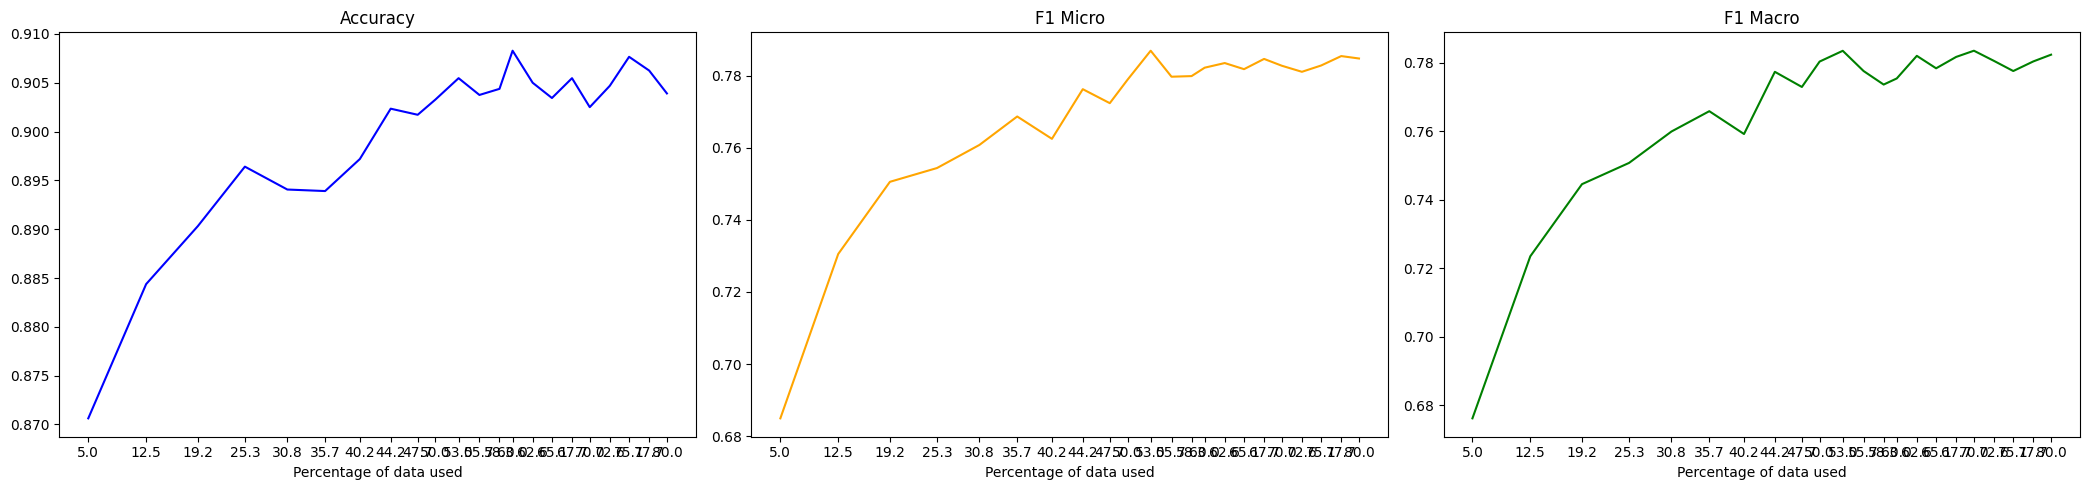

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6208, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4214, Accuracy: 0.8112, F1 Micro: 0.2063, F1 Macro: 0.149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3908, Accuracy: 0.827, F1 Micro: 0.3407, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3554, Accuracy: 0.8383, F1 Micro: 0.4408, F1 Macro: 0.3616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2953, Accuracy: 0.8547, F1 Micro: 0.5432, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2514, Accuracy: 0.8706, F1 Micro: 0.6607, F1 Macro: 0.6457
Epoch 8/10, Train Loss: 0.216, Accuracy: 0.8611, F1 Micro: 0.5946, F1 Macro: 0.5687
Epoch 9/10, Train Loss: 0.1615, Accuracy: 0.8661, F1 Micro: 0.6352, F1 Macro: 0.6212
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5617, Accuracy: 0.7944, F1 Micro: 0.0693, F1 Macro: 0.0585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4423, Accuracy: 0.8339, F1 Micro: 0.4098, F1 Macro: 0.3109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3327, Accuracy: 0.8698, F1 Micro: 0.6429, F1 Macro: 0.6292
Epoch 4/10, Train Loss: 0.2695, Accuracy: 0.8689, F1 Micro: 0.6256, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2393, Accuracy: 0.8852, F1 Micro: 0.7418, F1 Macro: 0.7394
Epoch 6/10, Train Loss: 0.189, Accuracy: 0.888, F1 Micro: 0.7239, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1507, Accuracy: 0.8859, F1 Micro: 0.7426, F1 Macro: 0.738
Epoch 8/10, Train Loss: 0.1133, Accuracy: 0.8892, F1 Micro: 0.7336, F1 Macro: 0.7242
Epoch 9/10, Train Loss: 0.0957, Accuracy: 0.8881, F1 Micro: 0.735, F1 Macro: 0.7295
Epoch 10/10, Train Loss: 0.0772, Accuracy: 0.8858, F1 Micro: 0.7386, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5099, Accuracy: 0.8214, F1 Micro: 0.2843, F1 Macro: 0.1895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3629, Accuracy: 0.8478, F1 Micro: 0.4689, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2788, Accuracy: 0.8781, F1 Micro: 0.6787, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2245, Accuracy: 0.8897, F1 Micro: 0.7312, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.8913, F1 Micro: 0.7405, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.8891, F1 Micro: 0.7495, F1 Macro: 0.7464
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.8917, F1 Micro: 0.7344, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.89, F1 Micro: 0.7538, F1 Macro: 0.7515
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.8903, F1 Micro: 0.7314, F1 Macro: 0.7226
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4884, Accuracy: 0.8473, F1 Micro: 0.5088, F1 Macro: 0.433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3134, Accuracy: 0.8733, F1 Micro: 0.6619, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2421, Accuracy: 0.8819, F1 Micro: 0.7561, F1 Macro: 0.757
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.8942, F1 Micro: 0.7471, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.8944, F1 Micro: 0.7677, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.8992, F1 Micro: 0.76, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.8959, F1 Micro: 0.7604, F1 Macro: 0.7589
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.8966, F1 Micro: 0.7532, F1 Macro: 0.7474
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.8958, F1 Micro: 0.7484, F1 Macro: 0.7377
Epoch 10/10, Train Loss: 0.0492, Accuracy: 0.8944, F1 Micro: 0.7478, F1 Macro: 0.7424
Iteration 1969: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4574, Accuracy: 0.8423, F1 Micro: 0.4742, F1 Macro: 0.3866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.883, F1 Micro: 0.7045, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2366, Accuracy: 0.8898, F1 Micro: 0.7226, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1946, Accuracy: 0.898, F1 Micro: 0.76, F1 Macro: 0.7529
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.8978, F1 Micro: 0.7536, F1 Macro: 0.7457
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.8959, F1 Micro: 0.7438, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.8955, F1 Micro: 0.7598, F1 Macro: 0.7509
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.8958, F1 Micro: 0.7561, F1 Macro: 0.7478
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.8994, F1 Micro: 0.7548, F1 Macro: 0.7443
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9008, F1 Micro: 0.7597, F1 Macro: 0.7545
Iteration 2394: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.8719, F1 Micro: 0.654, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.8895, F1 Micro: 0.7417, F1 Macro: 0.7383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.8961, F1 Micro: 0.7536, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.8961, F1 Micro: 0.7656, F1 Macro: 0.7647
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.8995, F1 Micro: 0.763, F1 Macro: 0.7557
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.8998, F1 Micro: 0.7549, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.8953, F1 Micro: 0.7677, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.8961, F1 Micro: 0.769, F1 Macro: 0.7697
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.8977, F1 Micro: 0.7587, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0371, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8525, F1 Micro: 0.5256, F1 Macro: 0.4543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.8853, F1 Micro: 0.6921, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.895, F1 Micro: 0.7591, F1 Macro: 0.7564
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.8969, F1 Micro: 0.7368, F1 Macro: 0.7244
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9006, F1 Micro: 0.7665, F1 Macro: 0.7609
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.8997, F1 Micro: 0.7603, F1 Macro: 0.7493
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.8977, F1 Micro: 0.7616, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9005, F1 Micro: 0.756, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.8961, F1 Micro: 0.7621, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9016, F1 Micro: 0.7675, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4279, Accuracy: 0.8797, F1 Micro: 0.6885, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.8863, F1 Micro: 0.7016, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.897, F1 Micro: 0.749, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9002, F1 Micro: 0.7733, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.8998, F1 Micro: 0.7726, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9028, F1 Micro: 0.773, F1 Macro: 0.7692
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9002, F1 Micro: 0.7712, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9014, F1 Micro: 0.7587, F1 Macro: 0.7493
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9006, F1 Micro: 0.7657, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.8995, F1 Micro: 0.7721, F1 Macro: 0.7714
Iteration 3432: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4185, Accuracy: 0.8723, F1 Micro: 0.6477, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.893, F1 Micro: 0.7577, F1 Macro: 0.7547
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.8966, F1 Micro: 0.7434, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.902, F1 Micro: 0.7711, F1 Macro: 0.7652
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.8984, F1 Micro: 0.741, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9005, F1 Micro: 0.7758, F1 Macro: 0.7725
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9022, F1 Micro: 0.7714, F1 Macro: 0.7696
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.8989, F1 Micro: 0.7727, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9027, F1 Micro: 0.7678, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8988, F1 Micro: 0.7759, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4051, Accuracy: 0.8756, F1 Micro: 0.6756, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.8938, F1 Micro: 0.7511, F1 Macro: 0.75
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9005, F1 Micro: 0.7495, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9019, F1 Micro: 0.7792, F1 Macro: 0.778
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.8991, F1 Micro: 0.7614, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.8981, F1 Micro: 0.7809, F1 Macro: 0.7851
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.903, F1 Micro: 0.7729, F1 Macro: 0.7694
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.8998, F1 Micro: 0.7598, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9011, F1 Micro: 0.7623, F1 Macro: 0.7584
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9036, F1 Micro: 0.7772, F1 Macro: 0.7753
Iteration 3886: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8767, F1 Micro: 0.7238, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.895, F1 Micro: 0.7593, F1 Macro: 0.7553
Epoch 3/10, Train Loss: 0.2094, Accuracy: 0.8978, F1 Micro: 0.7441, F1 Macro: 0.7344
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.8972, F1 Micro: 0.7485, F1 Macro: 0.7421
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9022, F1 Micro: 0.78, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9031, F1 Micro: 0.7626, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9027, F1 Micro: 0.7715, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.8992, F1 Micro: 0.7736, F1 Macro: 0.7698
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9005, F1 Micro: 0.7557, F1 Macro: 0.7487
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.8972, F1 Micro: 0.7773, F1 Macro: 0.7765
Iteration 4120: Accuracy: 0.9022, F1 Micro: 0.78, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4069, Accuracy: 0.8805, F1 Micro: 0.7245, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8959, F1 Micro: 0.7576, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.9017, F1 Micro: 0.7685, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9069, F1 Micro: 0.7817, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9047, F1 Micro: 0.763, F1 Macro: 0.7533
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9022, F1 Micro: 0.7704, F1 Macro: 0.7637
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9014, F1 Micro: 0.7736, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.9025, F1 Micro: 0.7751, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9031, F1 Micro: 0.7705, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9017, F1 Micro: 0.7697, F1 Macro: 0.7653
Iteration 4330: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8825, F1 Micro: 0.7147, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.8927, F1 Micro: 0.7632, F1 Macro: 0.7584
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9016, F1 Micro: 0.7537, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9027, F1 Micro: 0.7676, F1 Macro: 0.7547
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9042, F1 Micro: 0.767, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9003, F1 Micro: 0.7827, F1 Macro: 0.7843
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9023, F1 Micro: 0.7775, F1 Macro: 0.7777
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9028, F1 Micro: 0.7774, F1 Macro: 0.7749
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.8977, F1 Micro: 0.7685, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9009, F1 Micro: 0.7708, F1 Macro: 0.763
Iteration 4530: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8847, F1 Micro: 0.7172, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.8972, F1 Micro: 0.7552, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.8995, F1 Micro: 0.7678, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9038, F1 Micro: 0.7811, F1 Macro: 0.7791
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9008, F1 Micro: 0.7624, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9025, F1 Micro: 0.7635, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9045, F1 Micro: 0.7837, F1 Macro: 0.78
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9077, F1 Micro: 0.7822, F1 Macro: 0.7768
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9061, F1 Micro: 0.7815, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9008, F1 Micro: 0.776, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3857, Accuracy: 0.8825, F1 Micro: 0.7371, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2408, Accuracy: 0.8958, F1 Micro: 0.743, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9002, F1 Micro: 0.7479, F1 Macro: 0.7324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9058, F1 Micro: 0.7766, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.8991, F1 Micro: 0.7664, F1 Macro: 0.7593
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.8997, F1 Micro: 0.755, F1 Macro: 0.7375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9036, F1 Micro: 0.7778, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.902, F1 Micro: 0.7802, F1 Macro: 0.7792
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9006, F1 Micro: 0.7776, F1 Macro: 0.779
Epoch 10/10, Train Loss: 0.0302, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8817, F1 Micro: 0.6837, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.8972, F1 Micro: 0.7489, F1 Macro: 0.7423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.8981, F1 Micro: 0.7809, F1 Macro: 0.7831
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9013, F1 Micro: 0.7611, F1 Macro: 0.7588
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9023, F1 Micro: 0.7698, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9064, F1 Micro: 0.7686, F1 Macro: 0.76
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9017, F1 Micro: 0.7593, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9059, F1 Micro: 0.7811, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9044, F1 Micro: 0.7847, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9048, F1 Micro: 0.7788, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.8883, F1 Micro: 0.7303, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.8992, F1 Micro: 0.7576, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9042, F1 Micro: 0.7691, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9087, F1 Micro: 0.7768, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9005, F1 Micro: 0.7599, F1 Macro: 0.7503
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9, F1 Micro: 0.7709, F1 Macro: 0.7683
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9034, F1 Micro: 0.7692, F1 Macro: 0.7594
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.9055, F1 Micro: 0.7763, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9038, F1 Micro: 0.7817, F1 Macro: 0.7798
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9016, F1 Micro: 0.7744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8823, F1 Micro: 0.6829, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.8948, F1 Micro: 0.7349, F1 Macro: 0.714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1942, Accuracy: 0.9075, F1 Micro: 0.7771, F1 Macro: 0.7697
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9078, F1 Micro: 0.7757, F1 Macro: 0.7716
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9025, F1 Micro: 0.7555, F1 Macro: 0.7445
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9028, F1 Micro: 0.7766, F1 Macro: 0.7719
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9045, F1 Micro: 0.7695, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9073, F1 Micro: 0.786, F1 Macro: 0.7851
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9059, F1 Micro: 0.7817, F1 Macro: 0.7804
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9038, F1 Micro: 0.777, F1 Macro: 0.7734
Iteration 5441: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3612, Accuracy: 0.887, F1 Micro: 0.7055, F1 Macro: 0.6685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.9034, F1 Micro: 0.781, F1 Macro: 0.7789
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9048, F1 Micro: 0.7657, F1 Macro: 0.7586
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9036, F1 Micro: 0.7695, F1 Macro: 0.7629
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9016, F1 Micro: 0.7656, F1 Macro: 0.7602
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.8961, F1 Micro: 0.7769, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9047, F1 Micro: 0.7872, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9067, F1 Micro: 0.7869, F1 Macro: 0.7862
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8975, F1 Micro: 0.7713, F1 Macro: 0.7712
Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.883, F1 Micro: 0.7411, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9017, F1 Micro: 0.7725, F1 Macro: 0.7666
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.902, F1 Micro: 0.7638, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9053, F1 Micro: 0.7826, F1 Macro: 0.779
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9047, F1 Micro: 0.7804, F1 Macro: 0.7792
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.8983, F1 Micro: 0.7807, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8986, F1 Micro: 0.7757, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.903, F1 Micro: 0.7709, F1 Macro: 0.7667
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9031, F1 Micro: 0.775, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9042, F1 Micro: 0.7853, F1 Macro: 0.7872
Iteration 5841: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.8889, F1 Micro: 0.7391, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.8983, F1 Micro: 0.7713, F1 Macro: 0.7696
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9023, F1 Micro: 0.7632, F1 Macro: 0.7553
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.8995, F1 Micro: 0.7639, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.9061, F1 Micro: 0.7728, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.8997, F1 Micro: 0.761, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9002, F1 Micro: 0.7803, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9033, F1 Micro: 0.7712, F1 Macro: 0.7634
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.8998, F1 Micro: 0.777, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.8997, F1 Micro: 0.7659, F1 Macro: 0.7607
Iteration 6041: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3557, Accuracy: 0.8903, F1 Micro: 0.7394, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9034, F1 Micro: 0.7711, F1 Macro: 0.7629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.8994, F1 Micro: 0.7772, F1 Macro: 0.7726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.8992, F1 Micro: 0.7825, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9016, F1 Micro: 0.766, F1 Macro: 0.7528
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9039, F1 Micro: 0.7718, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9022, F1 Micro: 0.7662, F1 Macro: 0.7577
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9011, F1 Micro: 0.7694, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9013, F1 Micro: 0.7725, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.902, F1 Micro: 0.7684, F1 Macro: 0.7662
Iteration 6218: Accurac

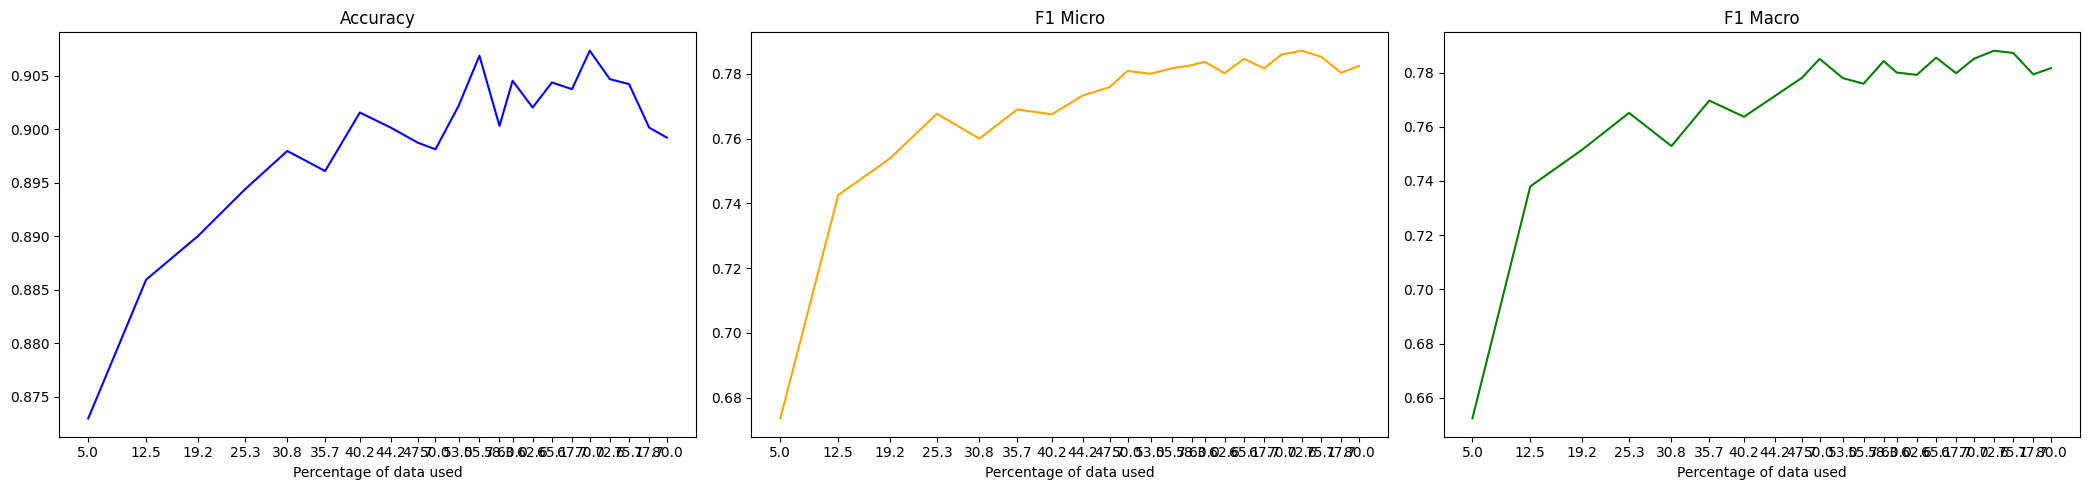

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5844, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4307, Accuracy: 0.7905, F1 Micro: 0.0346, F1 Macro: 0.0305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4004, Accuracy: 0.8223, F1 Micro: 0.2871, F1 Macro: 0.2055
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3618, Accuracy: 0.8373, F1 Micro: 0.4148, F1 Macro: 0.3304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.303, Accuracy: 0.8416, F1 Micro: 0.4416, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2804, Accuracy: 0.8517, F1 Micro: 0.5286, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2304, Accuracy: 0.8625, F1 Micro: 0.6068, F1 Macro: 0.5746
Epoch 8/10, Train Loss: 0.199, Accuracy: 0.8653, F1 Micro: 0.6009, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1798, Accuracy: 0.8691, F1 Micro: 0.64

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5315, Accuracy: 0.805, F1 Micro: 0.1579, F1 Macro: 0.1201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8345, F1 Micro: 0.4, F1 Macro: 0.3229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3337, Accuracy: 0.8661, F1 Micro: 0.6141, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.256, Accuracy: 0.8772, F1 Micro: 0.6836, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2052, Accuracy: 0.8816, F1 Micro: 0.6916, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1698, Accuracy: 0.8842, F1 Micro: 0.7269, F1 Macro: 0.7242
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.8838, F1 Micro: 0.7228, F1 Macro: 0.7178
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.8875, F1 Micro: 0.7211, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.8844, F1 Micro: 0.7305, F1 Macro: 0.7235
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4953, Accuracy: 0.8164, F1 Micro: 0.2482, F1 Macro: 0.1768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3571, Accuracy: 0.8695, F1 Micro: 0.6421, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.279, Accuracy: 0.8856, F1 Micro: 0.721, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.8923, F1 Micro: 0.7284, F1 Macro: 0.714
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.8861, F1 Micro: 0.6902, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.8913, F1 Micro: 0.7432, F1 Macro: 0.7396
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.8923, F1 Micro: 0.7355, F1 Macro: 0.7235
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.8909, F1 Micro: 0.7382, F1 Macro: 0.727
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.8911, F1 Micro: 0.7204, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0477, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4857, Accuracy: 0.8339, F1 Micro: 0.3887, F1 Macro: 0.318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.8789, F1 Micro: 0.7249, F1 Macro: 0.723
Epoch 3/10, Train Loss: 0.2409, Accuracy: 0.8859, F1 Micro: 0.7082, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2012, Accuracy: 0.8934, F1 Micro: 0.7385, F1 Macro: 0.7304
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.8922, F1 Micro: 0.7151, F1 Macro: 0.7053
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.8953, F1 Micro: 0.7493, F1 Macro: 0.7467
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.8922, F1 Micro: 0.7334, F1 Macro: 0.7263
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8945, F1 Micro: 0.7417, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8964, F1 Micro: 0.7544, F1 Macro: 0.7507
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.8922, F1 Micro: 0.7513, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8572, F1 Micro: 0.5956, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3005, Accuracy: 0.8864, F1 Micro: 0.7188, F1 Macro: 0.7195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.8933, F1 Micro: 0.7473, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.8941, F1 Micro: 0.7608, F1 Macro: 0.7599
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.8944, F1 Micro: 0.7596, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.8955, F1 Micro: 0.7471, F1 Macro: 0.7404
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.8952, F1 Micro: 0.7486, F1 Macro: 0.7434
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.8927, F1 Micro: 0.7515, F1 Macro: 0.7476
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.8947, F1 Micro: 0.7479, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8945, F1 Micro: 0.7423, F1 Macro: 0.7359
Iteration 2394: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8652, F1 Micro: 0.6058, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.8858, F1 Micro: 0.7163, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.8911, F1 Micro: 0.7182, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.8939, F1 Micro: 0.7687, F1 Macro: 0.7658
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.898, F1 Micro: 0.757, F1 Macro: 0.7509
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.8995, F1 Micro: 0.755, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.8869, F1 Micro: 0.7544, F1 Macro: 0.7513
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.8984, F1 Micro: 0.7575, F1 Macro: 0.7511
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.7548
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8959, F1 Micro: 0.7637, F1 Macro: 0.7617
Iteration 2777: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8597, F1 Micro: 0.572, F1 Macro: 0.5319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.893, F1 Micro: 0.7503, F1 Macro: 0.7394
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.8927, F1 Micro: 0.7231, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.8939, F1 Micro: 0.7579, F1 Macro: 0.7523
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.8978, F1 Micro: 0.7439, F1 Macro: 0.7303
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9006, F1 Micro: 0.7556, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.8955, F1 Micro: 0.7615, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.8906, F1 Micro: 0.7598, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.8975, F1 Micro: 0.762, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0361, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8769, F1 Micro: 0.6934, F1 Macro: 0.6911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.8911, F1 Micro: 0.7229, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.8994, F1 Micro: 0.7568, F1 Macro: 0.7508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9013, F1 Micro: 0.7666, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.8978, F1 Micro: 0.7681, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.8991, F1 Micro: 0.7521, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.8973, F1 Micro: 0.7729, F1 Macro: 0.7731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.902, F1 Micro: 0.775, F1 Macro: 0.7753
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9016, F1 Micro: 0.7704, F1 Macro: 0.7679
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4085, Accuracy: 0.8788, F1 Micro: 0.7139, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.8941, F1 Micro: 0.738, F1 Macro: 0.7269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.8994, F1 Micro: 0.7593, F1 Macro: 0.7547
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.8986, F1 Micro: 0.7462, F1 Macro: 0.7327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.8992, F1 Micro: 0.7681, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.8981, F1 Micro: 0.7613, F1 Macro: 0.7575
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9002, F1 Micro: 0.7518, F1 Macro: 0.7378
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9, F1 Micro: 0.7572, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.8981, F1 Micro: 0.7683, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4104, Accuracy: 0.8791, F1 Micro: 0.7088, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.8991, F1 Micro: 0.7527, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.8989, F1 Micro: 0.7535, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9009, F1 Micro: 0.7755, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8964, F1 Micro: 0.778, F1 Macro: 0.7781
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9025, F1 Micro: 0.7589, F1 Macro: 0.7557
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9019, F1 Micro: 0.7665, F1 Macro: 0.7613
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9044, F1 Micro: 0.7753, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9002, F1 Micro: 0.7577, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0322, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8792, F1 Micro: 0.7258, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8967, F1 Micro: 0.7672, F1 Macro: 0.7675
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9002, F1 Micro: 0.7634, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9039, F1 Micro: 0.7809, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.8963, F1 Micro: 0.7723, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.8977, F1 Micro: 0.7739, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9055, F1 Micro: 0.7869, F1 Macro: 0.7835
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9053, F1 Micro: 0.7825, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0345, Accuracy: 0.9056, F1 Micro: 0.781, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.88, F1 Micro: 0.7046, F1 Macro: 0.6876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2447, Accuracy: 0.8967, F1 Micro: 0.7704, F1 Macro: 0.7692
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.8931, F1 Micro: 0.77, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9038, F1 Micro: 0.7797, F1 Macro: 0.7776
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9023, F1 Micro: 0.7619, F1 Macro: 0.7507
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9036, F1 Micro: 0.7775, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9011, F1 Micro: 0.7714, F1 Macro: 0.7667
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9053, F1 Micro: 0.7729, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9023, F1 Micro: 0.7759, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.9016, F1 Micro: 0.776, F1 Macro: 0.7728
Iteration 4330: Accuracy: 0.9038, F1 Micro: 0.7797, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3931, Accuracy: 0.882, F1 Micro: 0.7184, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.8983, F1 Micro: 0.7712, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.898, F1 Micro: 0.7752, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9044, F1 Micro: 0.7799, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9028, F1 Micro: 0.7733, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9003, F1 Micro: 0.7703, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9052, F1 Micro: 0.7739, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.8998, F1 Micro: 0.7784, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.905, F1 Micro: 0.7723, F1 Macro: 0.7641
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8959, F1 Micro: 0.777, F1 Macro: 0.7749
Iteration 4530: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3934, Accuracy: 0.8777, F1 Micro: 0.6844, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8964, F1 Micro: 0.7655, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2093, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9028, F1 Micro: 0.781, F1 Macro: 0.7809
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9036, F1 Micro: 0.7764, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9045, F1 Micro: 0.7755, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9041, F1 Micro: 0.7782, F1 Macro: 0.7748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9083, F1 Micro: 0.7822, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9041, F1 Micro: 0.7693, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9062, F1 Micro: 0.7727, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.8839, F1 Micro: 0.7353, F1 Macro: 0.7343
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9005, F1 Micro: 0.7579, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.8995, F1 Micro: 0.7797, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.8991, F1 Micro: 0.7759, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.905, F1 Micro: 0.7835, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9045, F1 Micro: 0.7825, F1 Macro: 0.7786
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9044, F1 Micro: 0.7768, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9052, F1 Micro: 0.7766, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9042, F1 Micro: 0.7822, F1 Macro: 0.7794
Iteration 4863: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8844, F1 Micro: 0.733, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.8972, F1 Micro: 0.7374, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9016, F1 Micro: 0.7752, F1 Macro: 0.774
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9038, F1 Micro: 0.7622, F1 Macro: 0.7541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macro: 0.7784
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9055, F1 Micro: 0.7785, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9034, F1 Micro: 0.774, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.903, F1 Micro: 0.768, F1 Macro: 0.7645
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9025, F1 Micro: 0.7762, F1 Macro: 0.7717
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9048, F1 Micro: 0.7763, F1 Macro: 0.7725
Iteration 5063: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.88, F1 Micro: 0.7288, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9002, F1 Micro: 0.7741, F1 Macro: 0.771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.8991, F1 Micro: 0.7809, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9055, F1 Micro: 0.7846, F1 Macro: 0.7817
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.903, F1 Micro: 0.7802, F1 Macro: 0.7783
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9014, F1 Micro: 0.7724, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9019, F1 Micro: 0.7637, F1 Macro: 0.7528
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9034, F1 Micro: 0.7751, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9031, F1 Micro: 0.7655, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9056, F1 Micro: 0.7829, F1 Macro: 0.7806
Iteration 5263: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8856, F1 Micro: 0.6988, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.8984, F1 Micro: 0.7423, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9059, F1 Micro: 0.7727, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9031, F1 Micro: 0.7739, F1 Macro: 0.7703
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.8963, F1 Micro: 0.7712, F1 Macro: 0.7699
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9013, F1 Micro: 0.7654, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9027, F1 Micro: 0.7729, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.9002, F1 Micro: 0.7706, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9019, F1 Micro: 0.7815, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0287, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.8863, F1 Micro: 0.7263, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.8975, F1 Micro: 0.7709, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9008, F1 Micro: 0.7768, F1 Macro: 0.7709
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9039, F1 Micro: 0.7715, F1 Macro: 0.7657
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.8997, F1 Micro: 0.7741, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.8995, F1 Micro: 0.7693, F1 Macro: 0.7644
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9023, F1 Micro: 0.7681, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9047, F1 Micro: 0.781, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9055, F1 Micro: 0.772, F1 Macro: 0.7637
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9039, F1 Micro: 0.7728, F1 Macro: 0.7678
Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8872, F1 Micro: 0.6909, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9031, F1 Micro: 0.7614, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9009, F1 Micro: 0.7753, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.8969, F1 Micro: 0.771, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9077, F1 Micro: 0.7828, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.903, F1 Micro: 0.7765, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.902, F1 Micro: 0.7727, F1 Macro: 0.7683
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9034, F1 Micro: 0.7694, F1 Macro: 0.767
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9025, F1 Micro: 0.7744, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0.8978, F1 Micro: 0.7771, F1 Macro: 0.7756
Iteration 5841: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8867, F1 Micro: 0.7469, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9033, F1 Micro: 0.773, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9081, F1 Micro: 0.7814, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9062, F1 Micro: 0.7854, F1 Macro: 0.7804
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9059, F1 Micro: 0.7749, F1 Macro: 0.766
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9041, F1 Micro: 0.7767, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9033, F1 Micro: 0.7796, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9031, F1 Micro: 0.7818, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.902, F1 Micro: 0.7706, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9044, F1 Micro: 0.776, F1 Macro: 0.7683
Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3571, Accuracy: 0.8902, F1 Micro: 0.7225, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9016, F1 Micro: 0.7665, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9072, F1 Micro: 0.7832, F1 Macro: 0.7734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9039, F1 Micro: 0.7847, F1 Macro: 0.7823
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9044, F1 Micro: 0.7795, F1 Macro: 0.7769
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.8978, F1 Micro: 0.772, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9017, F1 Micro: 0.758, F1 Macro: 0.7511
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9041, F1 Micro: 0.7775, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9038, F1 Micro: 0.7776, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9069, F1 Micro: 0.7825, F1 Macro: 0.7765
Iteration 6218: Accu

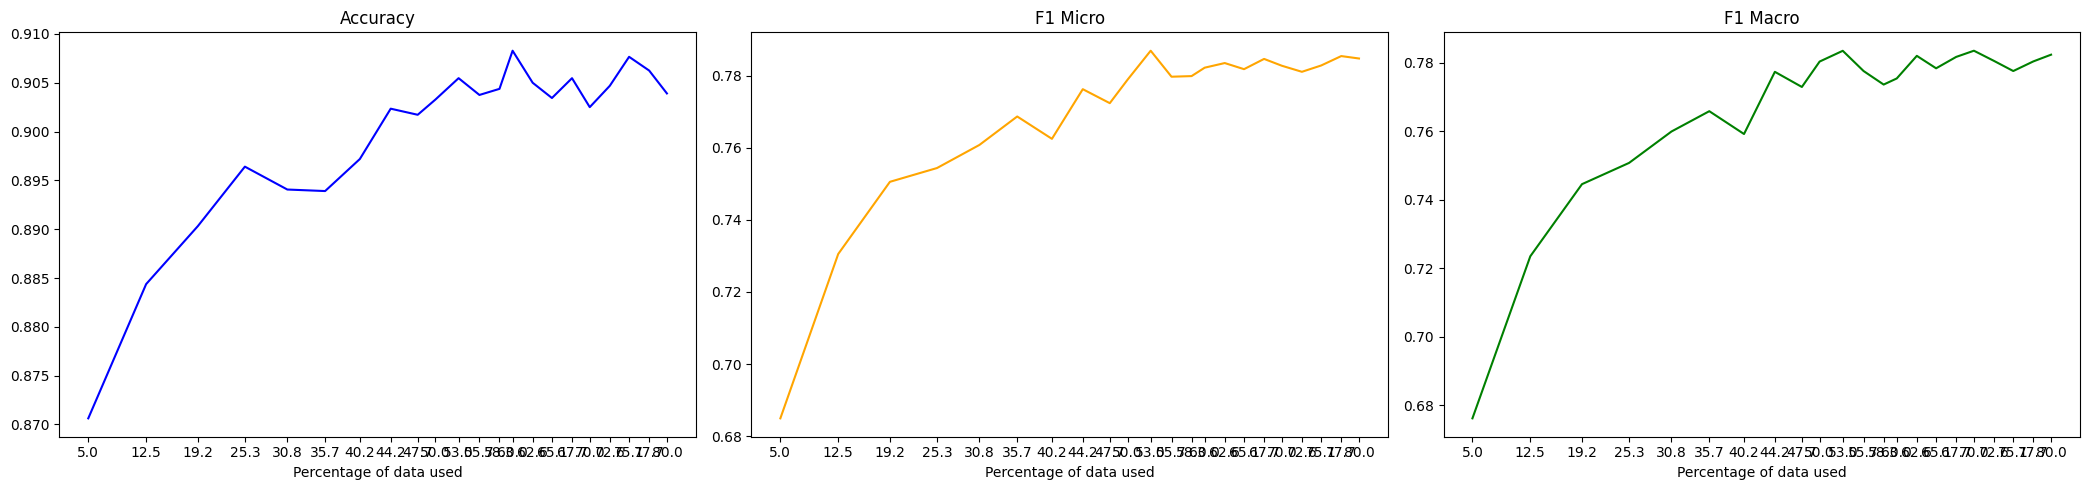

In [ ]:
active_learning(seeds[4], 4)